# Quantized FACILE Training with Brevitas
This notebook walks through the steps to train and and validate the Pytorch Brevitas reconstruction of the HCAL Facile model

Initial Pytorch conversion by Vladimir Oveckhin
Pytorch to Brevitas conversion by Matthew Trahms

In [1]:
#install pandas (missing in FINN env)
!pip install --user pandas

     |################################| 9.5MB 1.9MB/s eta 0:00:01


In [1]:
#import the necessary classes and functions
from train import train
from metrics import Metrics
from quant_model import QuantNet
from quant_modelV2 import QuantNet_opt
#from quantmodelV2_with_proc import QuantNet_opt_proc

In [2]:
models_folder = 'quant_models'

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Number of batches per epoch: 229538
# of Model parameters: 862.0
# of features: 14


Epoch 1
Ave Train Loss: 5.550768933486762
Ave Val Loss: 2.0705348871836153
Ave Q Train Loss: 361.8367520066475
Ave Q Val Loss: 131.09042548716593
<class 'quant_modelV2.QuantNet_opt'>
Min Ave Val Loss: 2.0705348871836153
Saved model


Epoch 2
Ave Train Loss: 2.207678474093922
Ave Val Loss: 2.0810310636633185
Ave Q Train Loss: 144.79399735541614
Ave Q Val Loss: 139.3939282422172
Min Ave Val Loss: 2.0705348871836153


Epoch 3
Ave Train Loss: 1.9920932887536336
Ave Val Loss: 2.2675221489183217
Ave Q Train Loss: 129.84816991668072
Ave Q Val Loss: 157.03360884800932
Min Ave Val Loss: 2.0705348871836153


Epoch 4
Ave Train Loss: 1.8767650568614112
Ave Val Loss: 1.644800870112447
Ave Q Train Loss: 122.91955403073817
Ave Q Val Loss: 103

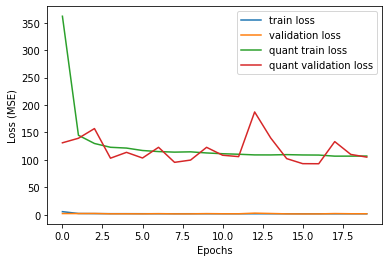

<class 'quant_modelV2.QuantNet_opt'>


In [3]:
#train (mimicing structure in train.py)
metrics = Metrics()
model = None
try:
    model = train(QuantNet_opt, metrics=metrics, models_folder_path=models_folder, quantized=True)
except KeyboardInterrupt:
    print("Interrupted")
finally:
    metrics.plot_losses()
print(type(model))

In [4]:
#test inference
import torch
import utils
from torch.utils.data import DataLoader
from processing_for_train import FACILE_preproc as preproc
from processing_for_train import FACILE_postproc as postproc
from processing_for_train import FACILE_preproc_out as preproc_out

batch_size=1
train_set, val_set, test_set, n_features = utils.load_torch_datasets()
gen_params = {
                "batch_size": batch_size,
                "shuffle": True,
            }
test_gen = DataLoader(val_set, **gen_params)#DataLoader(test_set, **gen_params)
#ensure model in evaluation mode
model.eval()
loss_fn = torch.nn.MSELoss()

total_test_loss = 0
total_test_loss_quant = 0
n_test_samples = 0

for test_batch, labels_batch in test_gen:
    n_test_samples += test_batch.shape[0]

    labels_batch_q = labels_batch
    labels_batch = preproc_out(labels_batch.float())
    output_batch = preproc(test_batch.float())
    output_batch = model(output_batch)
    #output_batch = postproc(output_batch).float()
    #output_batch = torch.trunc(output_batch)
    output_batch_quant = torch.round(output_batch)
    output_batch_quant = postproc(output_batch_quant)
    q_loss = loss_fn(output_batch_quant.float(), labels_batch_q.float())
    total_test_loss_quant += q_loss.item()
    loss = loss_fn(output_batch.float(), labels_batch.float())
    total_test_loss += loss.item()

ave_test_loss = total_test_loss / n_test_samples
ave_test_loss_q = total_test_loss_quant / n_test_samples

print(f"Ave Test Loss: {ave_test_loss}")
print(f"Ave Q Test Loss: {ave_test_loss_q}")

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Ave Test Loss: 1.7126659525465344
Ave Q Test Loss: 104.96397195488375


In [5]:
#export to onnx finn format
from brevitas.onnx import export_finn_onnx
input_shape = [1,14]
export_finn_onnx(model, input_shape, models_folder + "/facileV3_6b_1.onnx")#, batch_size=1)

In [6]:
from utils import load_split_np_data
import proc_for_infer as pfi
from finn.core.onnx_exec import execute_onnx as exe_onnx
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.transformation.infer_datatypes import InferDataTypes
print('imports')

imports


In [7]:
model = ModelWrapper("quant_models/facileV3_6b_1.onnx")
print('model loaded')

model loaded


In [ ]:
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
print('transformed')

In [12]:
in_tensor = model.graph.input[0].name
out_tensor = model.graph.output[0].name
print('tensors acq')

datasets = load_split_np_data()
print('datasets loaded, starting inf')

batch_size=1
inps = datasets[1]
exp_out = datasets[4]
valid_size = len(exp_out)
num_batches = int(valid_size/batch_size)
running_error_square = 0
for i in range(0, num_batches):
    #print(i)
    batch = inps[(i*batch_size):((i+1)*batch_size)]
    #print(batch.shape)
    batch_exp_out = exp_out[(i*batch_size):((i+1)*batch_size)]
    proc_batch = pfi.preproc(batch)
    #print(proc_batch.shape)
    proc_batch = proc_batch.astype("float32")
    inp_dict = {in_tensor : proc_batch}
    #print(inp_dict[in_tensor].shape)
    #batch_out = accel.execute(proc_batch)
    out_dict = exe_onnx(model, inp_dict)
    batch_out = out_dict[out_tensor]
    batch_out = batch_out.astype("int8")
    #print(batch_out)
    batch_proc_out = pfi.postproc(batch_out)
    batch_errs = batch_proc_out-batch_exp_out
    batch_sq_errs = batch_errs*batch_errs
    running_error_square += sum(batch_sq_errs)
print("MSE: " + str(running_error_square / (num_batches * batch_size)))

tensors acq
X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
datasets loaded, starting inf


Exception: Found unspecified tensor shapes, try infer_shapes